### Homework：加载本地保存的模型，进行评估和再训练更高的 F1 Score

In [1]:
# 根据你使用的模型和GPU资源情况，调整以下关键参数
squad_v2 = False
model_checkpoint = "distilbert-base-uncased"

加载数据集

In [2]:
from datasets import load_dataset

datasets = load_dataset("squad_v2" if squad_v2 else "squad")

预处理数据

In [3]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# The maximum length of a feature (question and context)
max_length = 384 
# The authorized overlap between two part of the context when splitting it is needed.
doc_stride = 128 

In [5]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [6]:
pad_on_right = tokenizer.padding_side == "right"

In [8]:
batch_size=64
model_dir = f"models/{model_checkpoint}-finetuned-squad"

args = TrainingArguments(
    output_dir=model_dir,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [9]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

trained_model = AutoModelForQuestionAnswering.from_pretrained(model_dir)

In [10]:
def prepare_train_features(examples):
    # 一些问题的左侧可能有很多空白字符，这对我们没有用，而且会导致上下文的截断失败
    # （标记化的问题将占用大量空间）。因此，我们删除左侧的空白字符。
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # 使用截断和填充对我们的示例进行标记化，但保留溢出部分，使用步幅（stride）。
    # 当上下文很长时，这会导致一个示例可能提供多个特征，其中每个特征的上下文都与前一个特征的上下文有一些重叠。
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # 由于一个示例可能给我们提供多个特征（如果它具有很长的上下文），我们需要一个从特征到其对应示例的映射。这个键就提供了这个映射关系。
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # 偏移映射将为我们提供从令牌到原始上下文中的字符位置的映射。这将帮助我们计算开始位置和结束位置。
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # 让我们为这些示例进行标记！
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # 我们将使用 CLS 特殊 token 的索引来标记不可能的答案。
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # 获取与该示例对应的序列（以了解上下文和问题是什么）。
        sequence_ids = tokenized_examples.sequence_ids(i)

        # 一个示例可以提供多个跨度，这是包含此文本跨度的示例的索引。
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # 如果没有给出答案，则将cls_index设置为答案。
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # 答案在文本中的开始和结束字符索引。
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # 当前跨度在文本中的开始令牌索引。
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # 当前跨度在文本中的结束令牌索引。
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # 检测答案是否超出跨度（在这种情况下，该特征的标签将使用CLS索引）。
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # 否则，将token_start_index和token_end_index移到答案的两端。
                # 注意：如果答案是最后一个单词（边缘情况），我们可以在最后一个偏移之后继续。
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [11]:
tokenized_datasets = datasets.map(prepare_train_features,
                                  batched=True,
                                  remove_columns=datasets["train"].column_names)

In [12]:
from transformers import default_data_collator

data_collator = default_data_collator

In [13]:
trained_trainer = Trainer(
    trained_model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

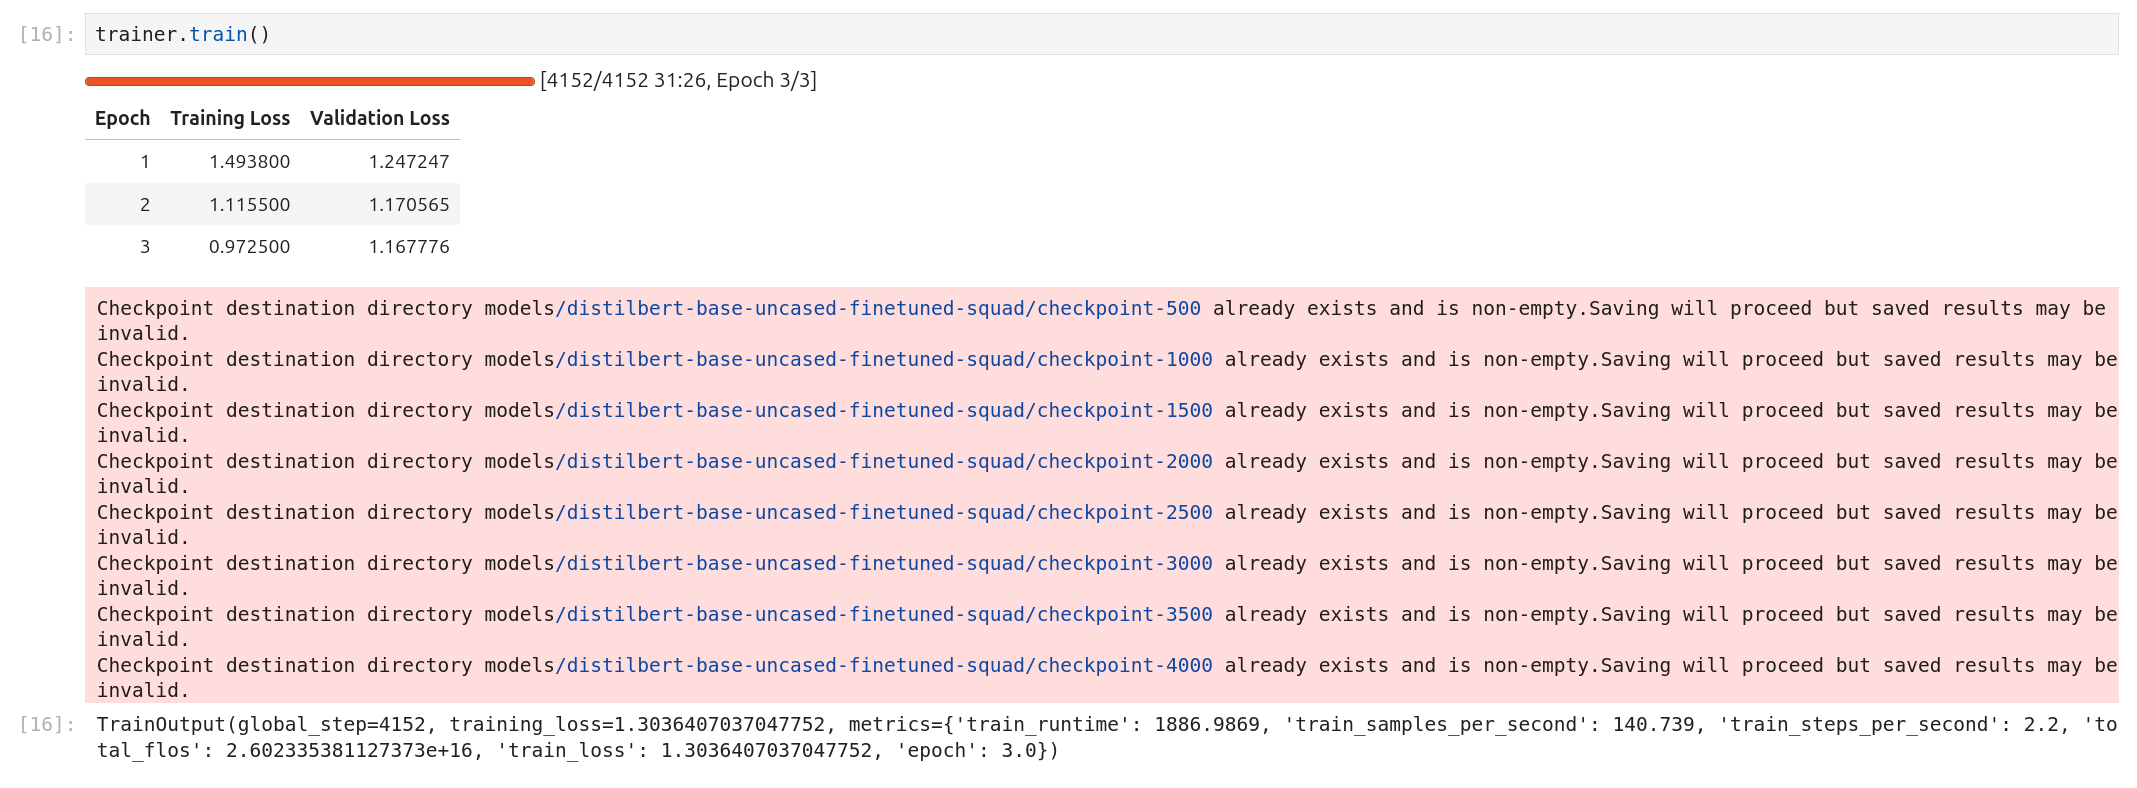
之前训练的结果作为对比

In [14]:
trained_trainer.train()


Epoch,Training Loss,Validation Loss
1,0.843800,1.209222
2,0.709800,1.240635
3,0.676200,1.261083


Checkpoint destination directory models/distilbert-base-uncased-finetuned-squad/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-base-uncased-finetuned-squad/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-base-uncased-finetuned-squad/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-base-uncased-finetuned-squad/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-base-uncased-finetuned-squad/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-base-uncased-finetuned-squad/checkpoint-

TrainOutput(global_step=4152, training_loss=0.7443996532344634, metrics={'train_runtime': 1906.6898, 'train_samples_per_second': 139.284, 'train_steps_per_second': 2.178, 'total_flos': 2.602335381127373e+16, 'train_loss': 0.7443996532344634, 'epoch': 3.0})

In [15]:
import torch

for batch in trained_trainer.get_eval_dataloader():
    break
batch = {k: v.to(trained_trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trained_trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [16]:
import numpy as np
n_best_size = 20
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()

# 获取最佳的起始和结束位置的索引：
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

valid_answers = []

# 遍历起始位置和结束位置的索引组合
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index:  # 需要进一步测试以检查答案是否在上下文中
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": ""  # 我们需要找到一种方法来获取与上下文中答案对应的原始子字符串
                }
            )


In [18]:
def prepare_validation_features(examples):
    # 一些问题的左侧有很多空白，这些空白并不有用且会导致上下文截断失败（分词后的问题会占用很多空间）。
    # 因此我们移除这些左侧空白
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # 使用截断和可能的填充对我们的示例进行分词，但使用步长保留溢出的令牌。这导致一个长上下文的示例可能产生
    # 几个特征，每个特征的上下文都会稍微与前一个特征的上下文重叠。
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # 由于一个示例在上下文很长时可能会产生几个特征，我们需要一个从特征映射到其对应示例的映射。这个键就是为了这个目的。
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # 我们保留产生这个特征的示例ID，并且会存储偏移映射。
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # 获取与该示例对应的序列（以了解哪些是上下文，哪些是问题）。
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # 一个示例可以产生几个文本段，这里是包含该文本段的示例的索引。
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # 将不属于上下文的偏移映射设置为None，以便容易确定一个令牌位置是否属于上下文。
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples


In [20]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names
)

In [21]:
raw_predictions = trained_trainer.predict(validation_features)


In [22]:
max_answer_length = 30

In [23]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [24]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]

# 第一个特征来自第一个示例。对于更一般的情况，我们需要将example_id匹配到一个示例索引
context = datasets["validation"][0]["context"]

# 收集最佳开始/结束逻辑的索引：
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # 不考虑超出范围的答案，原因是索引超出范围或对应于输入ID的部分不在上下文中。
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # 不考虑长度小于0或大于max_answer_length的答案。
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # 我们需要细化这个测试，以检查答案是否在上下文中
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers


[{'score': 13.670474, 'text': 'Denver Broncos'},
 {'score': 10.569526,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 8.5298605, 'text': 'Carolina Panthers'},
 {'score': 7.729567, 'text': 'Broncos'},
 {'score': 7.5452, 'text': 'Denver'},
 {'score': 4.851479,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina'},
 {'score': 4.6286187,
  'text': 'Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 3.8459883,
  'text': 'American Football Conference (AFC) champion Denver Broncos'},
 {'score': 3.8188825,
  'text': 'Denver Broncos defeated the National Football Conference'},
 {'score': 3.7434514,
  'text': 'Denver Broncos defeated the National Football Conference (NFC'},
 {'score': 3.713716,
  'text': 'Denver Broncos defeated the National Football Conference (NFC)'},
 {'score': 3.7008405,
  'text': 'Denver Broncos defeated the National Footb

In [25]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [26]:
from tqdm.notebook import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # 构建一个从示例到其对应特征的映射。
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # 我们需要填充的字典。
    predictions = collections.OrderedDict()

    # 日志记录。
    print(f"正在后处理 {len(examples)} 个示例的预测，这些预测分散在 {len(features)} 个特征中。")

    # 遍历所有示例！
    for example_index, example in enumerate(tqdm(examples)):
        # 这些是与当前示例关联的特征的索引。
        feature_indices = features_per_example[example_index]

        min_null_score = None # 仅在squad_v2为True时使用。
        valid_answers = []
        
        context = example["context"]
        # 遍历与当前示例关联的所有特征。
        for feature_index in feature_indices:
            # 我们获取模型对这个特征的预测。
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # 这将允许我们将logits中的某些位置映射到原始上下文中的文本跨度。
            offset_mapping = features[feature_index]["offset_mapping"]

            # 更新最小空预测。
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # 浏览所有的最佳开始和结束logits，为 `n_best_size` 个最佳选择。
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # 不考虑超出范围的答案，原因是索引超出范围或对应于输入ID的部分不在上下文中。
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # 不考虑长度小于0或大于max_answer_length的答案。
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # 在极少数情况下我们没有一个非空预测，我们创建一个假预测以避免失败。
            best_answer = {"text": "", "score": 0.0}
        
        # 选择我们的最终答案：最佳答案或空答案（仅适用于squad_v2）
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions


In [27]:
final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)

正在后处理 10570 个示例的预测，这些预测分散在 10784 个特征中。


  0%|          | 0/10570 [00:00<?, ?it/s]

In [28]:
from datasets import load_metric

metric = load_metric("squad_v2" if squad_v2 else "squad")

/tmp/ipykernel_243866/2330875496.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if squad_v2 else "squad")
/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for squad contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/squad/squad.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


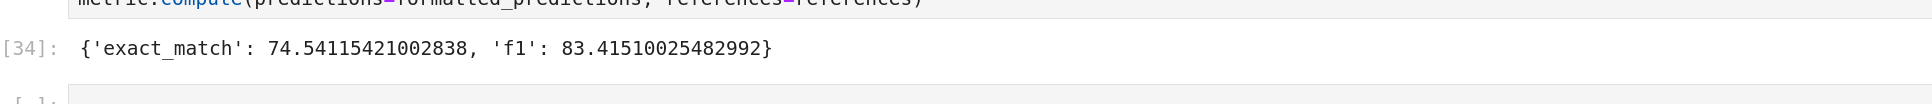
之前的评估结果，作为对比,确实提高了一点分数

In [30]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 75.22232734153263, 'f1': 84.04178638731332}